In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
from collections import defaultdict
from functools import partial
from itertools import repeat
def nested_defaultdict(default_factory, depth=1):
    result = partial(defaultdict, default_factory)
    for _ in repeat(None, depth-1):
        result = partial(defaultdict, result)
    return result()

def getDecisionTreeGraphic(estimator,feature_names,class_names):
    from sklearn import tree
    from io import StringIO
    import pydot_ng as pydot 
    import graphviz
    import matplotlib.pyplot as plt
    
    dot_data = StringIO()
    
      #                         class_names=classColumn,
    out = tree.export_graphviz(estimator,out_file=None,
                               feature_names=feature_names,
                               class_names=class_names,
                               filled=True, rounded=True,
                               special_characters=True,
                                node_ids=1,)
    import pydotplus
    pydot_graph = pydotplus.graph_from_dot_data(out)
    pydot_graph.set_size('"7,7!"')
    #print(pydot_graph.getvalue())
    #graph = graphviz.Source( out)
    graph = graphviz.Source(pydot_graph.to_string())
    return graph

In [5]:
short = "short_"
dfCombined = pd.DataFrame()
for d in range(10):
    print("processing digit: ", d)
    fname = "/home/wayne/main/git/data/ch3/digit_"+short+str(d)+".csv"
    df = pd.read_csv(fname, header=None)
    df['digit'] = d
    dfCombined = pd.concat([dfCombined, df])
print("length of dfCombined: ", len(dfCombined))
dfCombined.head()

processing digit:  0
processing digit:  1
processing digit:  2
processing digit:  3
processing digit:  4
processing digit:  5
processing digit:  6
processing digit:  7
processing digit:  8
processing digit:  9
length of dfCombined:  10000


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,digit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# function performance method
#def multiPerformance(y,y_pred,y_score,debug=False):
def multiPerformance(y,y_pred, debug=False):
#
# Make our matrix
    confusionMatrix = nested_defaultdict(int,2)
    classes = set()
    totalTrue = defaultdict(int)
    totalPred = defaultdict(int)
    for i in range(len(y_pred)):
        trueClass = y[i]
        classes.add(trueClass)
        predClass = y_pred[i]
        totalTrue[trueClass] += 1
        totalPred[predClass] += 1
        confusionMatrix[trueClass][predClass] += 1

    if debug:
        for trueClass in classes:
            print("True: ",trueClass,end="")
            for predClass in classes:
                print("\t",confusionMatrix[trueClass][predClass],end="")
            print()
        print()
    
    accMicro = 0.0
    accMacro = 0.0
    for cl in classes:
        accMicro += confusionMatrix[cl][cl]
        accMacro += confusionMatrix[cl][cl]/totalTrue[cl]
    accMicro /= len(y)
    accMacro = accMacro / len(classes)
    
    """
# add the "macro" averaged precision and recall
    TP = 0.0
    TF = 0.0
    FP = 0.0
    FN = 0.0
    precisionTotal = 0.0
    recallTotal = 0.0
    for i in range(len(classes)):
        TP_1 = 0.0
        TN_1 = 0.0
        FP_1 = 0.0
        FN_1 = 0.0
        TP_1 += confusionMatrix[i][i]
        for j in range(len(classes)):
            if j != i:
                TN_1 += confusionMatrix[j][j]
                FP_1 += confusionMatrix[i][j]
                FN_1 += confusionMatrix[j][i]
        precision_1 = TP_1/(TP_1 + FN_1)
        recall_1 = TP_1/(TP_1 + FP_1)
        precisionTotal += precision_1
        recallTotal += recall_1

    precisionMacro = precisionTotal/len(classes)
    recallMacro = recallTotal/len(classes)
    """
    results = {"confusionMatrix":confusionMatrix,"accuracyMicro":accMicro,"accuracyMacro":accMacro } #, "precisionMacro": precisionMacro, "recallMacro": recallMacro}
    return results

In [7]:
# function runFitter
def runFitter(estimator,X_train,y_train,X_test,y_test,debug=False):

    estimator.fit(X_train,y_train)

    y_train_pred = estimator.predict(X_train)
    #y_train_score = estimator.decision_function(X_train)   

    y_test_pred = estimator.predict(X_test)
    #y_test_score = estimator.decision_function(X_test)

    results_test = multiPerformance(y_test,y_test_pred,debug=False)
    results_train = multiPerformance(y_train,y_train_pred,debug=False)

    results = {
        'cf_test':results_test['confusionMatrix'],
        'cf_train':results_train['confusionMatrix'],
        'accuracyMicro_test':results_test['accuracyMicro'],
        'accuracyMacro_test':results_test['accuracyMacro'],
        'accuracyMicro_train':results_train['accuracyMicro'],
        'accuracyMacro_train':results_train['accuracyMacro'],
    }

    return results

In [10]:
# prepare data
from sklearn.utils import shuffle
df_shuffled = shuffle(dfCombined, random_state=404)
X = df_shuffled.to_numpy()[:,:784]
y = df_shuffled['digit'].values
print(len(X))
print(len(y))

10000
10000


In [11]:
# run fiiter with kfolds
from sklearn.model_selection import StratifiedKFold
kfolds = 5
skf = StratifiedKFold(n_splits=kfolds)

In [13]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, 
                             max_depth=5, 
                             random_state=404)
avg_accMicro_train = 0.0
avg_accMicro_test = 0.0
avg_accMacro_train = 0.0
avg_accMacro_test = 0.0
numSplits = 0.0

for train_index, test_index in skf.split(X, y):
    numSplits += 1
    print("data split ", numSplits)
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    results = runFitter(clf, X_train, y_train, X_test, y_test, debug=False)
    avg_accMicro_train += results['accuracyMicro_train']
    avg_accMacro_train += results['accuracyMacro_train']
    avg_accMicro_test += results['accuracyMicro_test']
    avg_accMacro_test += results['accuracyMacro_test']
avg_accMicro_train /= numSplits
avg_accMicro_test /= numSplits
avg_accMacro_train /= numSplits
avg_accMacro_test /= numSplits

print("Micro Accuracy train      ",round(avg_accMicro_train,3))
print("Micro Accuracy test       ",round(avg_accMicro_test,3))
print("Macro Accuracy train      ",round(avg_accMacro_train,3))
print("Macro Accuracy test       ",round(avg_accMacro_test,3))
print("")


data split  1.0
data split  2.0
data split  3.0
data split  4.0
data split  5.0
Micro Accuracy train       0.877
Micro Accuracy test        0.863
Macro Accuracy train       0.877
Macro Accuracy test        0.863



### finding the optimal max_depth

In [15]:
# loop up to max_depth = 25
dfError = pd.DataFrame(columns=['max_depth',
                               'trainError_accMicro',
                               'testError_accMicro',
                               'trainError_accMacro',
                               'testError_accMacro'])
for max_depth in range(1, 26):
    print("training with max_depth = ", max_depth)
    clf = RandomForestClassifier(n_estimators=100, 
                                 random_state=404,
                                max_depth = max_depth)
    avg_accMicro_train = 0.0
    avg_accMicro_test = 0.0
    avg_accMacro_train = 0.0
    avg_accMacro_test = 0.0
    numSplits = 0.0
#

    for train_index, test_index in skf.split(X, y):
        numSplits += 1
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]


        results = runFitter(clf,X_train,y_train,X_test,y_test,debug=False)

        avg_accMicro_train += results['accuracyMicro_train']
        avg_accMacro_train += results['accuracyMacro_train']
        avg_accMicro_test += results['accuracyMicro_test']
        avg_accMacro_test += results['accuracyMacro_test']

    avg_accMicro_train /= numSplits
    avg_accMacro_train /= numSplits
    avg_accMicro_test /= numSplits
    avg_accMacro_test /= numSplits
#
# Fill dataframe
    dfError = dfError.append({
        'max_depth':max_depth,
        'trainError_accMicro':1.0-avg_accMicro_train,'testError_accMicro':1.0-avg_accMicro_test,
        'trainError_accMacro':1.0-avg_accMacro_train,'testError_accMacro':1.0-avg_accMacro_test,
          }, ignore_index=True)
dfError.head()

training with max_depth =  1
training with max_depth =  2
training with max_depth =  3
training with max_depth =  4
training with max_depth =  5
training with max_depth =  6
training with max_depth =  7
training with max_depth =  8
training with max_depth =  9
training with max_depth =  10
training with max_depth =  11
training with max_depth =  12
training with max_depth =  13
training with max_depth =  14
training with max_depth =  15
training with max_depth =  16
training with max_depth =  17
training with max_depth =  18
training with max_depth =  19
training with max_depth =  20
training with max_depth =  21
training with max_depth =  22
training with max_depth =  23
training with max_depth =  24
training with max_depth =  25


,max_depth,trainError_accMicro,testError_accMicro,trainError_accMacro,testError_accMacro
0,1.0,0.382725,0.3897,0.382725,0.3897
1,2.0,0.287950,0.2956,0.287950,0.2956
2,3.0,0.219400,0.2275,0.219400,0.2275
3,4.0,0.166125,0.1776,0.166125,0.1776
4,5.0,0.122900,0.1371,0.122900,0.1371


### plot the accuracy vs max_depth

In [19]:
import chart_studio.plotly as py
import numpy as np
from plotly.offline import iplot
import plotly.graph_objs as go

trace1 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['trainError_accMacro'],
    mode = 'lines',
    name = 'Training error'
)

trace2 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['testError_accMacro'],
    mode = 'lines',
    name = 'Testing error'
)

layout = dict(
    title='Error (Macro accuracy) vs Model Complexity',
    xaxis = dict(title='max_depth'),
    yaxis = dict(title='Error (fraction)')
)

data = [trace1, trace2]
iplot(dict(data=data, layout=layout), validate=False)

trace3 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['trainError_accMicro'],
    mode = 'lines',
    name = 'Training error'
)

trace4 = go.Scatter(
    x = dfError['max_depth'],
    y = dfError['testError_accMicro'],
    mode = 'lines',
    name = 'Testing error'
)

layout = dict(
    title='Error (Micro accuracy) vs Model Complexity',
    xaxis = dict(title='max_depth'),
    yaxis = dict(title='Error (fraction)')
)

data = [trace3, trace4]
iplot(dict(data=data, layout=layout), validate=False)

###  max_depth = 12 is a good choice

In [28]:
from sklearn.ensemble import RandomForestClassifier
final_clf = RandomForestClassifier(n_estimators=100, 
                             max_depth=5, 
                             random_state=404)
avg_accMicro_train = 0.0
avg_accMicro_test = 0.0
avg_accMacro_train = 0.0
avg_accMacro_test = 0.0
numSplits = 0.0

for train_index, test_index in skf.split(X, y):
    numSplits += 1
    print("data split ", numSplits)
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    results = runFitter(final_clf, X_train, y_train, X_test, y_test, debug=False)
    avg_accMicro_train += results['accuracyMicro_train']
    avg_accMacro_train += results['accuracyMacro_train']
    avg_accMicro_test += results['accuracyMicro_test']
    avg_accMacro_test += results['accuracyMacro_test']
avg_accMicro_train /= numSplits
avg_accMicro_test /= numSplits
avg_accMacro_train /= numSplits
avg_accMacro_test /= numSplits

print("Micro Accuracy train      ",round(avg_accMicro_train,3))
print("Micro Accuracy test       ",round(avg_accMicro_test,3))
print("Macro Accuracy train      ",round(avg_accMacro_train,3))
print("Macro Accuracy test       ",round(avg_accMacro_test,3))
print("")


data split  1.0
data split  2.0
data split  3.0
data split  4.0
data split  5.0
Micro Accuracy train       0.877
Micro Accuracy test        0.863
Macro Accuracy train       0.877
Macro Accuracy test        0.863



### Feature importance

In [29]:
importanceByName = {}
for name, importance in zip(df_shuffled.columns[:784], final_clf.feature_importances_):
    importanceByName[name] = importance
#    print("Name,importance",name,round(importance,3))   

for name in sorted(importanceByName, key=importanceByName.get, reverse=True):
    print("Name", name, "importance", np.round(importanceByName[name], 3))
"""
importanceByName = {}
#print("unsorted importance")
for name,importance in zip(df_shuffled.columns[:784],clf.feature_importances_):
    importanceByName[name] = importance
    #print("Name,importance",name,round(importance,3))   
"""

Name 155 importance 0.016
Name 378 importance 0.016
Name 462 importance 0.015
Name 405 importance 0.014
Name 433 importance 0.014
Name 154 importance 0.014
Name 377 importance 0.011
Name 596 importance 0.011
Name 437 importance 0.011
Name 409 importance 0.01
Name 568 importance 0.01
Name 569 importance 0.01
Name 542 importance 0.009
Name 567 importance 0.009
Name 408 importance 0.009
Name 374 importance 0.009
Name 461 importance 0.009
Name 350 importance 0.009
Name 239 importance 0.009
Name 99 importance 0.009
Name 346 importance 0.008
Name 487 importance 0.008
Name 318 importance 0.008
Name 515 importance 0.008
Name 541 importance 0.008
Name 381 importance 0.008
Name 156 importance 0.008
Name 406 importance 0.007
Name 319 importance 0.007
Name 358 importance 0.007
Name 488 importance 0.007
Name 290 importance 0.007
Name 434 importance 0.007
Name 429 importance 0.007
Name 595 importance 0.007
Name 100 importance 0.007
Name 455 importance 0.007
Name 375 importance 0.007
Name 597 importa

'\nimportanceByName = {}\n#print("unsorted importance")\nfor name,importance in zip(df_shuffled.columns[:784],clf.feature_importances_):\n    importanceByName[name] = importance\n    #print("Name,importance",name,round(importance,3))   \n'

### plot the importances of all pixels

plot with matplotlib


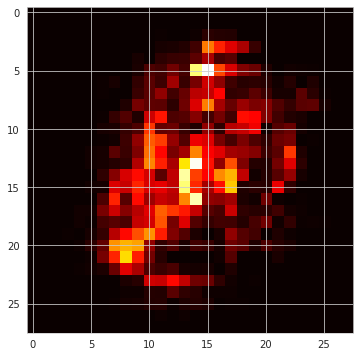


plot with plotly


In [32]:
importance = final_clf.feature_importances_
print("plot with matplotlib")
plt.figure(figsize=(6,6))
img = importance.reshape(28,28)
im = plt.imshow(img, cmap='hot')
plt.show()

print()
print("plot with plotly")
l1 = []
l2 = []
for i in range(28):
    l1.append(i)
    l2.append(27-i)
trace = go.Heatmap(
    z = importance.reshape(28,28),
    x = np.array(l1),
    y = np.array(l2),
    colorscale = 'Viridis'
)
layout = go.Layout(
    autosize = False,
    width = 500,
    height = 500
)
data = [trace]
fig = go.Figure(data=data, layout = layout)
iplot(fig)

In [41]:
# plotting test
l1 = []
l2 = []
for i in range(28):
    l1.append(i)
    l2.append(27-i)
trace = go.Heatmap(
    #z = importance.reshape(28,28),
    z = df_shuffled.iloc[3765].values[:784].reshape(28,28),
    x = np.array(l1),
    y = np.array(l2),
    colorscale = 'Viridis'
)
layout = go.Layout(
    autosize = False,
    width = 500,
    height = 500
)
data = [trace]
fig = go.Figure(data=data, layout = layout)
iplot(fig)

trace = go.Heatmap(
    #z = importance.reshape(28,28),
    z = df_shuffled.iloc[3765].values[:784].reshape(28,28),
    x = np.array(l1),
    y = np.array(l1),
    colorscale = 'Viridis'
)
layout = go.Layout(
    autosize = False,
    width = 500,
    height = 500
)
data = [trace]
fig = go.Figure(data=data, layout = layout)
iplot(fig)